In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved
# Licensed under the MIT License.
%matplotlib inline
import sys, os
sys.path.append("../")
from models.unet import UnetModel
import pickle
import torch
import numpy as np
from torch.autograd import Variable
from skimage.transform import resize
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import seaborn as sns
from skimage.draw import polygon
import fiona
import shapely
import rasterio
from shapely import geometry
from rasterio.mask import mask as rio_mask
import numpy as np
import cv2

In [2]:
RASTERIO_BEST_PRACTICES = dict(
    CURL_CA_BUNDLE='/etc/ssl/certs/ca-certificates.crt',
    GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
    AWS_NO_SIGN_REQUEST='YES',
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
    GDAL_SWATH_SIZE='200000000',
    VSI_CURL_CACHE_SIZE='200000000'
)

In [3]:
mean = [660.5929, 812.9481, 1080.6552, 1398.3968, 1662.5913, 1899.4804, 2061.932, 2100.2792, 2214.9325, 2230.5973, 2443.3014, 1968.1885],
std = [137.4943, 195.3494, 241.2698, 378.7495, 383.0338, 449.3187, 511.3159, 547.6335, 563.8937, 501.023, 624.041, 478.9655]

In [4]:
sentinel_urls = [
        "https://researchlabwuopendata.blob.core.windows.net/sentinel-2-imagery/karnataka_change/2020/2020_merged.tif"
    ]


In [5]:
def scale(x, min_val, max_val, a=0, b=255, output_type=np.uint8):
    y = np.clip((x - min_val) / (max_val - min_val), 0, 1)
    y = (b-a) * y + a
    y = y.astype(output_type)
    return y

def get_mask_and_bounding_geoms(geom, buffer):
    footprint_shape = shapely.geometry.shape(geom).buffer(0.0)
    bounding_shape = footprint_shape.envelope.buffer(buffer).envelope
    mask_geom = shapely.geometry.mapping(bounding_shape - footprint_shape) # full bounding area - initial footprint
    bounding_geom = shapely.geometry.mapping(bounding_shape) # full bounding area
    return mask_geom, bounding_geom

def get_sentinel_stack_from_geom(geom, buffer, urls):
    mask_geom, bounding_geom = get_mask_and_bounding_geoms(geom, buffer)
    images = []
    masks = []
    for url in urls:
        with rasterio.Env(**RASTERIO_BEST_PRACTICES):
            with rasterio.open(url) as f:
                mask_image, _ = rio_mask(f, [mask_geom], crop=True, invert=False, pad=False, all_touched=True)
                mask_image = np.rollaxis(mask_image, 0, 3)
                mask_image = mask_image[:,:,[3,2,1]]

                full_image, _ = rio_mask(f, [bounding_geom], crop=True, invert=False, pad=False, all_touched=True)
                full_image = np.rollaxis(full_image, 0, 3)
                full_image = full_image[:,:,[3,2,1]]
                full_image = scale(full_image, 0, 3000)

                mask = np.zeros((mask_image.shape[0], mask_image.shape[1]), dtype=np.uint8)
                mask[np.sum(mask_image == 0, axis=2) != 3] = 1
        images.append(full_image)
        masks.append(mask)
    return images, masks

def get_full_sentinel_stack_from_geom(geom, buffer, urls):
    mask_geom, bounding_geom = get_mask_and_bounding_geoms(geom, buffer)
    images = []
    for url in urls:
        with rasterio.Env(**RASTERIO_BEST_PRACTICES):
            with rasterio.open(url) as f:
                full_image, _ = rio_mask(f, [bounding_geom], crop=True, invert=False, pad=False, all_touched=True)
                full_image = np.rollaxis(full_image, 0, 3)
        images.append(full_image)
    return images



def get_sentinel_rgb_stack_from_geom(geom, buffer, urls):
    image_stack, masks  = get_sentinel_stack_from_geom(geom, buffer, urls)
    return image_stack


In [6]:
plt.rcParams.update({'font.size': 15})

def plot_sample_prediction(image, pred):
    '''
    Plots and a slice with all available annotations
    '''
    image = resize(image, (512, 512, 3), anti_aliasing=True)
    pred = resize(pred, (512, 512), anti_aliasing=True)
    flatui = ["#3498db", "#FFD700"]
    #flatui = ["#3498db", "#651FFF"]
    color_map = ListedColormap(sns.color_palette(flatui).as_hex())

    legend_elements = [
                   Line2D([0], [0], marker='o', color='w', label='Solar Farm Prediction', markerfacecolor=color_map(1), markersize=15)]

    fig = plt.figure(figsize=(18, 18))

    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.axis("off")
    
    plt.subplot(1, 4, 2)
    plt.imshow(image)
    pred = np.ma.masked_where(pred == 0, pred)
    plt.imshow(pred, alpha=0.5, interpolation='none', cmap=color_map, vmin=0, vmax=1)
    plt.axis("off")
   # plt.title('Prediction Overlay')

    plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1))
    plt.tight_layout()
    


In [7]:
def get_all_geoms_from_file(fn):
    geoms = []
    with fiona.open(fn) as f:
        for row in f:
            geom = row["geometry"]
            geoms.append(geom)
    return geoms

In [8]:
geoms = get_all_geoms_from_file("../temporal-cluster-matching/data/karnataka_predictions_polygons_validated_2020.geojson")


In [9]:
gpu_ids = [0]
device = torch.device('cuda:{}'.format(gpu_ids[0]) if torch.cuda.is_available() else 'cpu')
model_dir = "../data/models/unet_hnm"


class InferenceFramework():
    def __init__(self, model, opts):
        self.opts = opts
        self.model = model(self.opts)
        self.model.to(device)

    def load_model(self, path_2_model):
        checkpoint = torch.load(path_2_model)
        self.model.load_state_dict(checkpoint['model'])
        self.model.eval()

    def predict_single_image(self, x):
        y_pred = self.model.forward(x.unsqueeze(0))
        return np.squeeze(np.argmax((Variable(y_pred).data).cpu().numpy(), axis=1))


def load_options(file_name):
    opt = pickle.load(open(file_name + '.pkl', 'rb'))
    return opt


def get_prediction(x, opts, model_dir):
    if opts.model == "unet":
        model = UnetModel
    else:
        raise NotImplementedError

    inf_framework = InferenceFramework(
        model,
        opts
    )
    inf_framework.model.to(device)
    inf_framework.load_model(os.path.join(model_dir, "checkpoint.pth.tar"))

    y_hat = inf_framework.predict_single_image(torch.from_numpy(x).float().to(device))
    return y_hat

In [10]:
def get_predictions(images):
    predictions = []
    opts = load_options(model_dir +'/opt')
    for img in images:
        img = cv2.resize(img, (256, 256))
        x = (img-mean) / std 
        x = np.moveaxis(x, 2, 0)
        y_hat = np.squeeze(get_prediction(x, opts, model_dir))
        contours = find_contours(y_hat, 0.5)
        solar_mask = np.zeros(y_hat.shape)
        for n, contour in enumerate(contours):
        # Construct the rotatedbox. If its aspect ratio is too small, we ignore it 
            ll, ur = np.min(contour, 0), np.max(contour, 0)
            wh = ur - ll
            if wh[0] * wh[1] < 5:
                continue
            else:
                #fill mask for solar farm
                rr, cc = polygon(contour[:, 0], contour[:, 1], solar_mask.shape)
                solar_mask[rr, cc] = 1

        predictions.append(solar_mask)
    return predictions


In [11]:
i = 5
shape_area = geometry.shape(geoms[i]).area
side_length = np.sqrt(shape_area)
buffer_size = max(side_length * 1.5, 0.001)
images = get_full_sentinel_stack_from_geom(geoms[i], buffer=buffer_size, urls=sentinel_urls)
predictions = get_predictions(images)
rgb_images = get_sentinel_rgb_stack_from_geom(geoms[i], buffer=buffer_size, urls=sentinel_urls)

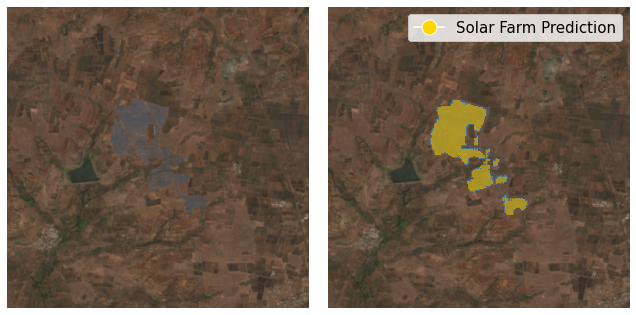

In [12]:
plot_sample_prediction(rgb_images[0], predictions[0])